# Set up

In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm
from linear_operator import settings

import pyro
import math
import pickle
import time
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import arviz as az
import seaborn as sns

import os
import scipy.stats as stats

In [2]:
import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

In [3]:
Device = 'cpu'

In [ ]:
Device = 'cuda'

# Data

In [4]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

# Y_train_8 = pd.read_csv('Data/Y_train_8.csv', header=None, delimiter=',').values
# Y_test_8 = pd.read_csv('Data/Y_test_8.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values

In [5]:
train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

# train_y_8 = torch.tensor(Y_train_8, dtype=torch.float32)
# test_y_8 = torch.tensor(Y_test_8, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_21, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)

# Emulator

## L.MGP

In [6]:
row_idx = 0

input_point = test_y_21[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k=500)

MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_MultitaskGP(
    local_train_x, local_train_y, n_tasks = local_train_y.shape[1], 
    covar_type = 'RBF', lr=0.05, num_iterations=5000, patience=10, device=Device)

## MVGP

In [ ]:
MVGP_models, MVGP_likelihoods = Training.train_full_MultitaskVGP(train_x, train_y_21, covar_type = 'RQ',
                                                                 num_latents=20, num_inducing=100, 
                                                                 lr_hyper=0.05, lr_variational=0.1, num_iterations=5000, patience=50, device=Device)

In [ ]:
checkpoint = torch.load('multitask_gp_checkpoint.pth', map_location=Device)
model_params = checkpoint['model_params']

In [6]:
checkpoint = torch.load('multitask_gp_checkpoint_21.pth', map_location=Device)
model_params = checkpoint['model_params']

C:\Users\r4718\AppData\Local\Temp\ipykernel_36012\3191163538.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('multitask_gp_checkpoint_21.pth', ma

In [7]:
MVGP_models = GP_models.MultitaskVariationalGP(train_x, train_y_21, 
                                               num_latents=model_params['num_latents'], 
                                               num_inducing=model_params['num_inducing'], 
                                               covar_type=model_params['covar_type']).to(Device)

MVGP_models.load_state_dict(checkpoint['model_state_dict'])

MVGP_likelihoods = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y_21.shape[1]).to(Device)
MVGP_likelihoods.load_state_dict(checkpoint['likelihood_state_dict'])

MVGP_models.eval()
MVGP_likelihoods.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

# MCMC

In [8]:
row_idx = 0

input_point = test_y_21[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k = 100)
# local_train_x, local_train_y = Tools.find_k_nearest_neighbors_GPU(input_point, train_x, train_y_21, k = 100)

bounds = bound.get_bounds(local_train_x)

In [14]:
bounds

[(1.3358, 4.9763),
 (0.352, 4.9804),
 (0.5599, 4.9481),
 (0.1833, 4.9606),
 (0.554, 3.9467),
 (0.1463, 4.9827),
 (1.229, 4.9982),
 (0.1019, 4.9824),
 (2.3695, 4.9992),
 (0.6, 4.9104)]

## priori is Uniform(min, max)

In [9]:
def run_mcmc_Uniform(Pre_function, Models, Likelihoods, row_idx, test_y, bounds, num_sampling=2000, warmup_step=1000, num_chains=1, device='cpu'):
    test_y = test_y.to(dtype=torch.float32, device=device)
    
    bounds = [
        (
            torch.tensor(b[0], dtype=torch.float32, device=device),
            torch.tensor(b[1], dtype=torch.float32, device=device)
        ) for b in bounds
    ]
    
    def model():
        params = []
        for i, (min_val, max_val) in enumerate(bounds):
            param_i = pyro.sample(f'param_{i}', dist.Uniform(min_val, max_val))
            params.append(param_i)
        
        theta = torch.stack(params)
        
        gp_pred = Pre_function(Models, Likelihoods, theta.unsqueeze(0))
        
        y_obs = test_y[row_idx, :]
        pyro.sample('obs', gp_pred, obs=y_obs)
    
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=num_sampling, warmup_steps=warmup_step, num_chains=num_chains)
    
    mcmc.run()
    
    return mcmc

In [12]:
mcmc_result_1 = run_mcmc_Uniform(Prediction.preds_distribution, 
                                 MVGP_models, MVGP_likelihoods, 
                                 row_idx, test_y_21, bounds, num_sampling = 1200, warmup_step = 300, num_chains=1, device=Device)



Sample: 100%|██████████| 1500/1500 [15:13,  1.64it/s, step size=1.47e-01, acc. prob=0.855]


In [9]:
estimated_params_tmp, _ = Estimation.multi_start_estimation(
        MVGP_models, MVGP_likelihoods, row_idx, test_y_21, bounds,
        Estimation.estimate_params_for_one_model_Adam, num_starts=4, num_iterations=1000, lr=0.01,
        patience=10, attraction_threshold=0.1, repulsion_strength=0.1, device=Device
    )

In [12]:
estimated_params_tmp

array([3.7026682, 4.8245025, 1.4787601, 4.7064342, 2.8382494, 0.6419074,
       2.970614 , 3.6429796, 4.72382  , 1.9229645], dtype=float32)

In [13]:
test_x[row_idx]

tensor([3.6700, 4.8642, 1.4330, 4.7406, 2.8699, 0.6171, 3.0394, 3.4495, 4.7810,
        1.8129])

In [19]:
mcmc_result_1 = Estimation.run_mcmc_Uniform(
    Prediction.preds_distribution_fast_pred_var, MultitaskGP_models, MultitaskGP_likelihoods, 
    row_idx, test_y_21, bounds, 
    num_sampling=1500, warmup_step=500, num_chains=1, device=Device
    )

Sample: 100%|██████████| 2000/2000 [09:01,  3.70it/s, step size=6.24e-01, acc. prob=0.853]


In [20]:
samples_1 = mcmc_result_1.get_samples()

torch.save(samples_1, "mcmc_samples_6.pt")

In [ ]:
loaded_samples = torch.load("mcmc_samples_1.pt", map_location=Device)

/tmp/ipykernel_2805618/2724127973.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_samples = torch.load("mcmc_samples_1.pt", map_location=Device)


In [32]:
test_x[0]

tensor([3.6700, 4.8642, 1.4330, 4.7406, 2.8699, 0.6171, 3.0394, 3.4495, 4.7810,
        1.8129])

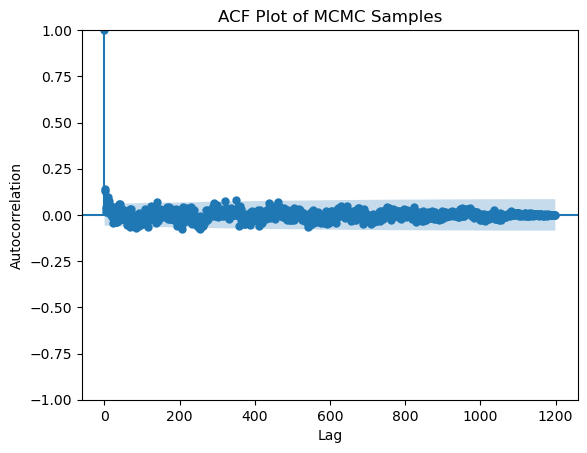

In [43]:
import matplotlib.pyplot as plt
import statsmodels.api as sm


sm.graphics.tsa.plot_acf(mcmc_samples['param_0'], lags=1200-1)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF Plot of MCMC Samples')
plt.show()


In [56]:
autocorrelation(mcmc_samples['param_0'], dim=0)

tensor([ 1.0000,  0.1397,  0.1300,  ..., -0.2734, -0.1437, -0.0209])

In [57]:
import statsmodels

statsmodels.tsa.stattools.acf(mcmc_samples['param_0'], nlags=1199)

array([ 1.00000000e+00,  1.39612778e-01,  1.29770658e-01, ...,
       -6.83436690e-04, -2.39515672e-04, -1.74405883e-05])

In [ ]:
pyro.ops.stats.autocorrelation(loaded_samples['param_0'], dim=0)

tensor([ 1.0000,  0.1397,  0.1300,  ..., -0.2734, -0.1437, -0.0209])

## priori is Uniform(0.1, 5)

In [ ]:
def run_mcmc_Uniform_2(Pre_function, Models, Likelihoods, row_idx, test_y, bounds, num_sampling=2000, warmup_step=1000, num_chains=1):
    test_y = test_y.to(dtype=torch.float32)
    bounds = [(torch.tensor(b[0], dtype=torch.float32), torch.tensor(b[1], dtype=torch.float32)) for b in bounds]
    
    def model():

        params = []
        for i, (min_val, max_val) in enumerate(bounds):
            param_i = pyro.sample(f'param_{i}', dist.Uniform(0.1, 5))
            params.append(param_i)
        
        theta = torch.stack(params)

        gp_pred = Pre_function(Models, Likelihoods, theta.unsqueeze(0))

        y_obs = test_y[row_idx, :]
        pyro.sample('obs', gp_pred, obs=y_obs)

    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=num_sampling, warmup_steps=warmup_step, num_chains=num_chains)
    mcmc.run()

    return mcmc

In [ ]:
import cProfile, pstats
profiler = cProfile.Profile()
profiler.enable()
mcmc_result_2 = run_mcmc_Uniform_2(Prediction.preds_distribution, MVGP_models, MVGP_likelihoods, row_idx, test_y_21, bounds, 
                                            num_sampling = 1200, warmup_step = 300, num_chains=1)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()


In [ ]:
samples_2 = mcmc_result_2.get_samples()

torch.save(samples_2, "mcmc_samples_2.pt")

# loaded_samples = torch.load("mcmc_samples_1.pt")

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from tqdm import tqdm

def run_mcmc_MH(Pre_function, Models, Likelihoods, row_idx, test_y, bounds, 
                num_sampling=2000, warmup_step=1000, proposal_std=0.1, num_chains=1):


    test_y = test_y.to(dtype=torch.float32)
    bounds = [(torch.tensor(b[0], dtype=torch.float32), torch.tensor(b[1], dtype=torch.float32)) for b in bounds]

    theta_dim = len(bounds)
    current_theta = torch.tensor([torch.rand(1).item() * (b[1] - b[0]) + b[0] for b in bounds], 
                                 dtype=torch.float32, requires_grad=False)
    
    samples = []
    current_log_prob = None

    with torch.no_grad():
        gp_pred = Pre_function(Models, Likelihoods, current_theta.unsqueeze(0))
        y_obs = test_y[row_idx, :]
        likelihood = torch.exp(-torch.norm(gp_pred - y_obs, p=2))
        prior = 1.0
        current_log_prob = torch.log(likelihood * prior)

    # Metropolis-Hastings 采样过程
    for step in tqdm(range(num_sampling)):
        # 生成新样本：从正态提议分布 q(x' | x) 采样
        proposal = current_theta + proposal_std * torch.randn_like(current_theta)

        # 约束参数在边界范围内
        for i in range(theta_dim):
            proposal[i] = torch.clamp(proposal[i], bounds[i][0], bounds[i][1])

        # 计算新样本的对数后验
        with torch.no_grad():
            gp_pred = Pre_function(Models, Likelihoods, proposal.unsqueeze(0))
            likelihood = torch.exp(-torch.norm(gp_pred - y_obs, p=2))
            new_log_prob = torch.log(likelihood * prior)

        # 计算接受率 alpha
        alpha = torch.exp(new_log_prob - current_log_prob)  # 计算接受比率
        acceptance_prob = torch.min(torch.tensor(1.0), alpha)  # 确保接受概率不超过 1

        # 采样是否接受
        if torch.rand(1).item() < acceptance_prob:
            current_theta = proposal.clone()
            current_log_prob = new_log_prob  # 更新后验值
        
        # 记录样本（丢弃 warmup 期间的采样）
        if step >= warmup_step:
            samples.append(current_theta.clone())

    return torch.stack(samples)  # 返回采样参数的 Tensor


# END